In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
R-peak validation pipeline — clean v2
-------------------------------------
What this does:
  1) Load ECG from TDMS (returns Python datetime start, not Arrow)
  2) Read LabVIEW RR (.lvm) robustly (comma/dot decimals; sec/ms/µs)
  3) Detect ECG R-peaks (NeuroKit2)
  4) Build LabVIEW R-peak *sample indices* from RR (+ header/time-based offsets)
  5) Compute refined offset around header-derived base offset (optional 60s clip)
  6) Create binary trains (0/1), align with overlap, estimate small lag
  7) Report TP/FP/FN/Sens/PPV/F1 before/after lag
  8) (Optional) Sweep NeuroKit2 cleaning methods and export CSV

Requires: pandas, numpy, neurokit2, nptdms, arrow, scipy, matplotlib
"""

from __future__ import annotations
import re
from typing import Tuple, Dict, Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate, convolve
import neurokit2 as nk
import nptdms
import arrow
from datetime import datetime

# ============================
# I/O helpers
# ============================

def read_labview_rr(path: str, skiprows: int = 22) -> np.ndarray:
    """Read RR intervals (seconds) from LabVIEW .lvm or text file."""
    try:
        df = pd.read_csv(path, sep="\t", engine="python", skiprows=skiprows, header=0, decimal=",")
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", skiprows=skiprows, header=0)
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))

    # choose plausible RR column
    cols = [c for c in df.columns if str(c).lower() not in ("x_value", "xvalue", "comment")]
    rr = None
    if "Untitled" in df.columns:
        rr = pd.to_numeric(df["Untitled"], errors="coerce").dropna().to_numpy(float)

    if rr is None:
        for c in cols:
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy(float)
            if v.size:
                med = float(np.nanmedian(v))
                if 0.1 < med < 5.0:
                    rr = v; break
        if rr is None and cols:
            rr = pd.to_numeric(df[cols[0]], errors="coerce").dropna().to_numpy(float)

    if rr is None or rr.size == 0:
        raise ValueError("Could not find an RR column in the provided LabVIEW file.")

    # unit normalization
    med = float(np.nanmedian(rr))
    if med > 10000:   # microseconds
        rr = rr / 1_000_000.0
    elif med > 5:     # milliseconds
        rr = rr / 1_000.0
    return rr


def rr_to_peak_samples(rr_seconds: Iterable[float], fs: float, t0_s: float = 0.0) -> np.ndarray:
    """Convert RR (sec) to absolute peak sample indices (int), first peak at t0_s."""
    rr = np.asarray(rr_seconds, dtype=float).ravel()
    t_peaks = t0_s + np.cumsum(np.insert(rr, 0, 0.0))
    return np.rint(t_peaks * fs).astype(np.int64)


def make_binary_series(peak_samples: np.ndarray, n_samples: Optional[int], left_pad: int = 0, right_pad: int = 0) -> np.ndarray:
    """Create a binary series with ones at peak positions, with optional padding."""
    peaks = np.asarray(peak_samples, dtype=int)
    if n_samples is None:
        length = (int(peaks.max()) + 1 if peaks.size else 0) + left_pad + right_pad
    else:
        length = int(n_samples) + left_pad + right_pad
    x = np.zeros(length, dtype=np.uint8)
    shifted = peaks + left_pad
    valid = shifted[(shifted >= 0) & (shifted < length)]
    x[valid] = 1
    return x

# ============================
# Time parsing & TDMS helpers
# ============================

def read_header_datetime_lvm(path: str, default_date_fmt: str = "%Y/%m/%d") -> Optional[datetime]:
    """
    Parse 'Date' and 'Time' from a LabVIEW .lvm header before ***End_of_Header***.
    Returns a naive datetime (no tz) if found; otherwise None.
    """
    date_val = None
    time_val = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            ls = line.strip()
            if ls.startswith("***End_of_Header***"):
                break
            low = ls.lower()
            if low.startswith("date\t") and date_val is None:
                date_val = ls.split("\t", 1)[1].strip()
            elif "time" in low and "time_pref" not in low and low.startswith("time\t") and time_val is None:
                time_val = ls.split("\t", 1)[1].strip()

    if not time_val:
        return None

    m = re.match(r"^(\d{2}:\d{2}:\d{2})[,.](\d+)$", time_val)
    if m:
        hhmmss, frac = m.group(1), m.group(2)
        if len(frac) > 6 and int(frac[6]) >= 5:
            frac6 = str(int(frac[:6]) + 1).zfill(6)
        else:
            frac6 = frac[:6].ljust(6, "0")
        time_norm = f"{hhmmss}.{frac6}"
        t_dt = datetime.strptime(time_norm, "%H:%M:%S.%f")
    else:
        if not re.match(r"^\d{2}:\d{2}:\d{2}$", time_val):
            return None
        t_dt = datetime.strptime(time_val, "%H:%M:%S")

    if date_val:
        fmts = [default_date_fmt, "%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"]
        for fmt in fmts:
            try:
                d = datetime.strptime(date_val, fmt).date()
                return datetime.combine(d, t_dt.time())
            except ValueError:
                continue
        return t_dt
    return t_dt


def _dt_from_any(v, assume_tz: str = "UTC", out_tz: Optional[str] = "Europe/Copenhagen", naive: bool = True) -> Optional[datetime]:
    """Parse any datetime-like to Python datetime; Arrow only used internally for DST."""
    try:
        a = arrow.get(pd.to_datetime(v))
        if a.tzinfo is None:
            a = a.replace(tzinfo=assume_tz)
        if out_tz:
            a = a.to(out_tz)
        return a.naive if naive else a.datetime
    except Exception:
        return None


def _find_time_in_props_dt(props: dict,
                           assume_tz="UTC",
                           out_tz="Europe/Copenhagen",
                           naive=True) -> Optional[datetime]:
    if not isinstance(props, dict):
        return None
    keys = (
        "wf_start_time",
        "ni_expstarttimestamp",
        "ni_exptimestamp",
        "wf_start",
        "start_time",
        "time",
    )
    for k, v in props.items():
        kl = str(k).lower()
        if any(tag in kl for tag in keys) and v is not None:
            dt = _dt_from_any(v, assume_tz=assume_tz, out_tz=out_tz, naive=naive)
            if dt is not None:
                return dt
    return None


def _extract_fs_from_props(props: dict, default_fs=512.0) -> float:
    if not isinstance(props, dict):
        return float(default_fs)
    for key in ("wf_increment", "increment", "dt"):
        if key in props and props[key] not in (None, ""):
            try:
                inc = float(props[key])
                if inc > 0:
                    return 1.0 / inc
            except Exception:
                pass
    for key in ("wf_sample_rate", "sample_rate", "sampling_rate", "rate"):
        if key in props and props[key] not in (None, ""):
            try:
                return float(props[key])
            except Exception:
                pass
    return float(default_fs)


def extract_tdms_ecg_and_time(
    tdms_path: str,
    prefer_group: Optional[str] = None,
    prefer_channel: Optional[str] = None,
    assume_tz: str = "UTC",
    out_tz: str = "Europe/Copenhagen",
    naive_return: bool = True,
) -> Tuple[pd.Series, float, Optional[datetime]]:
    """Return (ECG_series, fs, start_datetime_or_None) — start time is a Python datetime."""
    tdms = nptdms.TdmsFile.read(tdms_path)
    file_props = getattr(tdms, "properties", {}) or {}
    file_dt = _find_time_in_props_dt(file_props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return)

    channels = []
    for g in tdms.groups():
        for ch in g.channels():
            try:
                data = ch[:]
            except Exception:
                data = ch.data
            if data is None:
                continue
            arr = np.asarray(data)
            if arr.dtype.kind in ("i", "u", "f"):
                channels.append((g.name, ch.name, arr, ch.properties))
    if not channels:
        raise RuntimeError("No numeric channels found in TDMS.")

    if prefer_group and prefer_channel:
        chosen = next((t for t in channels if t[0]==prefer_group and t[1]==prefer_channel), None)
        if chosen is None:
            raise RuntimeError(f"Channel {prefer_group}.{prefer_channel} not found.")
    else:
        ekg_like = [t for t in channels if "ekg" in t[1].lower() or "ecg" in t[1].lower()]
        chosen = ekg_like[0] if ekg_like else channels[0]

    gname, cname, arr, props = chosen
    fs = _extract_fs_from_props(props)
    ch_dt = _find_time_in_props_dt(props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return) or file_dt

    ecg = pd.Series(arr, name=f"{gname}.{cname}")
    return ecg, fs, ch_dt

# ============================
# Peak detection & metrics
# ============================

def detect_ecg_peaks(signal: pd.Series, fs: float, clean_method: str = "neurokit") -> np.ndarray:
    """Clean ECG and return R-peak indices (global sample indices)."""
    cleaned = nk.ecg_clean(signal.to_numpy(), sampling_rate=int(fs), method=clean_method)
    peaks_dict, _ = nk.ecg_peaks(cleaned, sampling_rate=int(fs))
    binary = peaks_dict.get("ECG_R_Peaks")
    if binary is None:
        for v in peaks_dict.values():
            try:
                binary = np.asarray(v); break
            except Exception:
                continue
    idx = np.flatnonzero(np.asarray(binary, dtype=np.uint8))
    return idx


# def event_metrics_overlap_lag(gold_idx: np.ndarray,
#                               test_idx: np.ndarray,
#                               fs: float,
#                               tol_ms: float = 40.0,
#                               max_lag_ms: float = 150.0) -> Dict[str, float]:
#     """Compute TP/FP/FN/Sensitivity/PPV/F1 after overlap + best small lag + tolerance window."""
#     gold_idx = np.asarray(gold_idx, dtype=int)
#     test_idx = np.asarray(test_idx, dtype=int)

#     lo = max(gold_idx.min(), test_idx.min())
#     hi = min(gold_idx.max(), test_idx.max())
#     if hi <= lo:
#         raise ValueError("No temporal overlap between peak sequences.")

#     g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo
#     t = test_idx[(test_idx >= lo) & (test_idx < hi)] - lo
#     N = int(hi - lo)
#     a = np.zeros(N, dtype=np.uint8); a[g] = 1
#     b = np.zeros(N, dtype=np.uint8); b[t] = 1

#     maxlag = int(round(max_lag_ms/1000.0*fs))
#     bestlag = 0; best = -1
#     for lag in range(-maxlag, maxlag+1):
#         if lag < 0:
#             score = int((a[:lag] & b[-lag:]).sum())
#         elif lag > 0:
#             score = int((a[lag:] & b[:-lag]).sum())
#         else:
#             score = int((a & b).sum())
#         if score > best:
#             best, bestlag = score, lag

#     if bestlag > 0:
#         b2 = b[bestlag:]; a2 = a[:len(b2)]
#     elif bestlag < 0:
#         a2 = a[-bestlag:]; b2 = b[:len(a2)]
#     else:
#         a2, b2 = a, b

#     tol = int(round(tol_ms/1000.0*fs))
#     win = np.ones(2*tol+1, dtype=int)
#     TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
#     FP = int(int(b2.sum()) - TP)
#     FN = int(int(a2.sum()) - TP)
#     sens = TP/(TP+FN) if (TP+FN) > 0 else np.nan
#     ppv  = TP/(TP+FP) if (TP+FP) > 0 else np.nan
#     f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

#     return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1,
#                 lag_samples=bestlag, tol_samples=tol, N_overlap=len(a2), lo=lo, hi=lo+len(a2))

def event_metrics_overlap_lag(
    gold_idx: np.ndarray,
    test_idx: np.ndarray,
    fs: float,
    tol_ms: float = 40.0,         # alias for slack-ms (for bagudkomp.)
    max_lag_ms: float = 150.0,
    match_mode: str = "one_to_one"  # "one_to_one" eller "many_to_one"
) -> Dict[str, float]:
    """
    Compute TP/FP/FN/Sensitivity/PPV/F1 med:
      - overlap-udsnit
      - bedste lille lag (±max_lag_ms)
      - slack-vindue ±tol_ms (alias "slack")

    match_mode:
      - "one_to_one": greedy 1-til-1 matching (anbefalet til peak-evaluering)
      - "many_to_one": din tidligere convolution-baserede optælling
    """
    import numpy as np
    from scipy.signal import convolve

    gold_idx = np.asarray(gold_idx, dtype=int)
    test_idx = np.asarray(test_idx, dtype=int)

    # --- Overlap ---
    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    if hi <= lo:
        raise ValueError("No temporal overlap between peak sequences.")

    g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo
    t = test_idx[(test_idx >= lo) & (test_idx < hi)] - lo
    N = int(hi - lo)

    # Binary serier for lag-scan
    a = np.zeros(N, dtype=np.uint8); a[g] = 1
    b = np.zeros(N, dtype=np.uint8); b[t] = 1

    # --- Best small lag (samples) ---
    maxlag = int(round(max_lag_ms/1000.0*fs))
    bestlag = 0; best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    # Shift ud fra bestlag og få tilbage til *indeks-lister* i overlap
    if bestlag > 0:
        # b rykkes "frem" => drop de første bestlag fra a for aligneret længde
        a2 = a[bestlag:]; b2 = b[:-bestlag]; start = lo + bestlag
    elif bestlag < 0:
        a2 = a[:bestlag]; b2 = b[-bestlag:]; start = lo
    else:
        a2, b2 = a, b; start = lo

    g2 = np.flatnonzero(a2) + (start - lo)  # tilbage i overlap-akse
    t2 = np.flatnonzero(b2) + (start - lo)

    # --- Slack matching ---
    slack_samp = int(round(tol_ms/1000.0*fs))

    if match_mode == "many_to_one":
        # Din gamle metode (dilation) – svarer til "slack"-vinduet via convolution
        win = np.ones(2*slack_samp+1, dtype=int)
        # Bemærk: her bruger vi a2/b2 (lag-korrigerede binære)
        TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
        FP = int(int(b2.sum()) - TP)
        FN = int(int(a2.sum()) - TP)

    elif match_mode == "one_to_one":
        # Greedy 1-til-1 matching i sample-akse (to pointers)
        i = j = 0; TP = 0
        while i < len(g2) and j < len(t2):
            d = t2[j] - g2[i]
            if abs(d) <= slack_samp:
                TP += 1
                i += 1; j += 1
            elif d < -slack_samp:
                j += 1
            else:
                i += 1
        FP = len(t2) - TP
        FN = len(g2) - TP

    else:
        raise ValueError("match_mode must be 'one_to_one' or 'many_to_one'.")

    sens = TP/(TP+FN) if (TP+FN) > 0 else np.nan
    ppv  = TP/(TP+FP) if (TP+FP) > 0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

    return dict(
        TP=int(TP), FP=int(FP), FN=int(FN),
        Sensitivity=sens, PPV=ppv, F1=f1,
        lag_samples=int(bestlag),
        tol_samples=int(slack_samp),
        N_overlap=len(a2),
        lo=int(lo), hi=int(lo+len(a2)),
        match_mode=match_mode
    )


# ============================
# Offset refinement & proof
# ============================

def _count_matches(g_idx, t_idx, fs, offset_s, tol_ms=40.0, limit_first_s=None):
    tol_s = tol_ms / 1000.0
    g = np.asarray(g_idx, int)
    t = np.asarray(t_idx, int) + int(round(offset_s * fs))
    if limit_first_s is not None:
        g = g[g/fs <= limit_first_s]
        t = t[t/fs <= limit_first_s]
    gt = g / fs
    tt = t / fs
    i = j = 0; TP = 0
    while i < len(gt) and j < len(tt):
        dt = tt[j] - gt[i]
        if abs(dt) <= tol_s:
            TP += 1; i += 1; j += 1
        elif dt < -tol_s:
            j += 1
        else:
            i += 1
    return TP


def compute_refined_offset_around_base(
    base_offset_s: float, fs: float,
    lab_idx_base: np.ndarray, nk_idx: np.ndarray,
    *, refine_half_range_s: float = 30.0,
    refine_step_ms: float = 4.0,
    refine_first_s: float = 15*60.0,
    tol_ms: float = 40.0,
) -> tuple[float, pd.DataFrame]:
    """
    Find 'delta' omkring base_offset_s, men skub **LabVIEW** (ikke NK).
    Returnerer (refined_offset_s, df_deltas), hvor refined = base + best_delta.
    +delta betyder: skub LabVIEW SENERE (til højre).
    """

    def _count_matches_lab_shift(g_idx, t_idx, fs, delta_s, tol_ms=40.0, limit_first_s=None):
        tol_s = tol_ms / 1000.0
        g = np.asarray(g_idx, int) + int(round(delta_s * fs))   # <-- skub LabVIEW
        t = np.asarray(t_idx, int)
        if limit_first_s is not None:
            g = g[g/fs <= limit_first_s]
            t = t[t/fs <= limit_first_s]
        gt = g / fs; tt = t / fs
        i = j = 0; TP = 0
        while i < len(gt) and j < len(tt):
            dt = tt[j] - gt[i]
            if abs(dt) <= tol_s:
                TP += 1; i += 1; j += 1
            elif dt < -tol_s:
                j += 1
            else:
                i += 1
        return TP

    step_s = refine_step_ms / 1000.0
    deltas = np.arange(-refine_half_range_s, refine_half_range_s + step_s, step_s)

    rows = []
    for d in deltas:
        tp = _count_matches_lab_shift(
            lab_idx_base, nk_idx, fs, d,
            tol_ms=tol_ms, limit_first_s=refine_first_s
        )
        rows.append((d, tp))
    df = pd.DataFrame(rows, columns=["delta_s", "TP"]).sort_values("delta_s").reset_index(drop=True)

    best_row = df.iloc[df["TP"].argmax()]
    best_delta = float(best_row["delta_s"])
    refined_offset_s = base_offset_s + best_delta
    return refined_offset_s, df



def prove_alignment(ecg, fs, lab_idx, nk_idx, *, tol_ms=40, best_off_s=0.0,
                    max_lag_ms=150.0, plot_window=(100, 10),lab_idx_base=None):
    """Apply given offset to NK, print lengths/ranges/overlap, find best small lag, report metrics, plot window."""
    tol_samp = int(round(tol_ms/1000.0*fs))
    maxlag = int(round(max_lag_ms/1000.0*fs))

    print("=== BEFORE OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}, range={lab_idx.max()-lab_idx.min()}")
    print(f"NeuroKit idx: n={len(nk_idx)}, min={nk_idx.min()}, max={nk_idx.max()}, range={nk_idx.max()-nk_idx.min()}")
    if len(lab_idx) != len(nk_idx):
        print(f"[INFO] Different number of peaks ({len(lab_idx)} vs {len(nk_idx)}) — expected.\n")

    nk_idx_off = nk_idx + int(round(best_off_s * fs))
    print(f"[OFFSET] Using LABVIEW refined offset baked into lab_idx (no NK shift).")

    print("\n=== AFTER OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}")
    print(f"NeuroKit (offset) idx: n={len(nk_idx_off)}, min={nk_idx_off.min()}, max={nk_idx_off.max()}")
    overlap_start = max(lab_idx.min(), nk_idx_off.min())
    overlap_end   = min(lab_idx.max(), nk_idx_off.max())
    overlap_len   = overlap_end - overlap_start
    print(f"[INFO] Overlap range: {overlap_start}–{overlap_end} ({overlap_len/fs:.2f} s, {overlap_len} samples)")

    if overlap_len <= 0:
        raise ValueError("No temporal overlap after applying offset.")

    N = int(overlap_len)
    a = np.zeros(N, dtype=np.uint8); 
    b = np.zeros(N, dtype=np.uint8)
    a[lab_idx[(lab_idx>=overlap_start) & (lab_idx<overlap_end)] - overlap_start] = 1
    b[nk_idx_off[(nk_idx_off>=overlap_start) & (nk_idx_off<overlap_end)] - overlap_start] = 1
    print(f"[DEBUG] Binary lengths: lab={len(a)}, nk={len(b)}, sum(lab)={a.sum()}, sum(nk)={b.sum()}")

    bestlag, _ = 0, 0
    # small lag search
    best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    print(f"[LAG] Best small lag = {bestlag:+d} samples (~{bestlag/fs*1000:.1f} ms)")

    win = np.ones(2*tol_samp+1, dtype=int)
    def metrics_from_bins(A, B):
        TP = int((convolve(A, win, mode='same') * B > 0).sum())
        FP = int(B.sum() - TP)
        FN = int(A.sum() - TP)
        sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
        ppv  = TP/(TP+FP) if (TP+FP)>0 else np.nan
        f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan
        return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1)

    base_m = metrics_from_bins(a, b)
    if bestlag > 0:
        A2 = a[bestlag:]; B2 = b[:-bestlag]
    elif bestlag < 0:
        A2 = a[:bestlag];  B2 = b[-bestlag:]
    else:
        A2, B2 = a, b
    best_m = metrics_from_bins(A2, B2)

    print("\n[OVERLAP METRICS]")
    print(f"Before lag:  TP={base_m['TP']}, FP={base_m['FP']}, FN={base_m['FN']}, F1={base_m['F1']:.4f}")
    print(f" After lag:  TP={best_m['TP']}, FP={best_m['FP']}, FN={best_m['FN']}, F1={best_m['F1']:.4f}")

    # best_off_s = KNOWN_OFF_S + base_off_s - refined_offset_s

        # --- Plot ---
    start_s, dur_s = plot_window
    s = int(start_s*fs); e = int((start_s+dur_s)*fs)

    # Windowed indices
    lab_loc = lab_idx[(lab_idx>=s) & (lab_idx<e)] - s          # refined
    nk_loc  = nk_idx[(nk_idx>=s) & (nk_idx<e)] - s

    plt.figure(figsize=(12,4))
    t = np.arange(s,e)/fs
    plt.plot(t, ecg.values[s:e], label="ECG")  # line stays blue

    # LabVIEW (refined): GREEN TRIANGLES (distinct from blue ECG)
    if len(lab_loc):
        plt.scatter(t[lab_loc], ecg.values[s:e][lab_loc],
                    s=30, marker='^', color='tab:green', edgecolors='k',
                    linewidths=0.5, zorder=3, label="LabVIEW peaks (refined)")

    # NK peaks: ORANGE DOTS
    if len(nk_loc):
        plt.scatter(t[nk_loc], ecg.values[s:e][nk_loc],
                    s=24, color='tab:orange', edgecolors='k',
                    linewidths=0.5, zorder=3, label="NK peaks")

    # Optional: show LabVIEW base (if provided by caller)
    if 'lab_idx_base' in locals() and lab_idx_base is not None:
        lab_base_loc = lab_idx_base[(lab_idx_base>=s) & (lab_idx_base<e)] - s
        if len(lab_base_loc):
            plt.scatter(t[lab_base_loc], ecg.values[s:e][lab_base_loc],
                        s=24, marker='x', color='tab:green', linewidths=1.0,
                        zorder=3, label="LabVIEW peaks (base)")

    plt.title(f"Visual check (window {start_s}-{start_s+dur_s}s); lag best = {bestlag} samp")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



    return {
        "applied_offset_s": float(best_off_s),
        "best_lag_samples": int(bestlag),
        "before_overlap_metrics": base_m,
        "after_overlap_metrics": best_m,
    }

def plot_comparison_window(ecg, fs, nk_idx, lab_idx_refined, lab_idx_base=None,
                           start_s=100.0, dur_s=8.0, clean_method="neurokit"):
    """
    Plot a short window comparing:
      - raw ECG (line)
      - cleaned ECG (line)
      - NK peaks (orange dots)
      - LabVIEW peaks (refined) as green triangles
      - LabVIEW peaks (base) as green X (optional)
    """
    # Clean ECG for visualization (same method you used in detection)
    cleaned = nk.ecg_clean(ecg.to_numpy(), sampling_rate=int(fs), method=clean_method)

    s = int(start_s*fs); e = int((start_s+dur_s)*fs)
    t = np.arange(s, e)/fs

    nk_loc   = nk_idx[(nk_idx>=s) & (nk_idx<e)] - s
    lab_loc  = lab_idx_refined[(lab_idx_refined>=s) & (lab_idx_refined<e)] - s
    base_loc = None
    if lab_idx_base is not None:
        base_loc = lab_idx_base[(lab_idx_base>=s) & (lab_idx_base<e)] - s

    plt.figure(figsize=(12,4))
    # Raw & cleaned lines
    plt.plot(t, ecg.values[s:e],               label="ECG (raw)",     alpha=0.8)
    plt.plot(t, cleaned[s:e],                  label=f"ECG (cleaned: {clean_method})", alpha=0.9)

    # Peaks
    if nk_loc.size:
        plt.scatter(t[nk_loc], cleaned[s:e][nk_loc],
                    s=28, color='tab:orange', edgecolors='k',
                    linewidths=0.5, zorder=3, label="NK peaks")

    if lab_loc.size:
        plt.scatter(t[lab_loc], cleaned[s:e][lab_loc],
                    s=34, marker='^', color='tab:green', edgecolors='k',
                    linewidths=0.5, zorder=3, label="LabVIEW peaks (refined)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], cleaned[s:e][base_loc],
                    s=30, marker='x', color='tab:green', linewidths=1.0,
                    zorder=3, label="LabVIEW peaks (base)")

    plt.title(f"Comparison window {start_s:.1f}–{start_s+dur_s:.1f}s")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# ============================
# Optional: NK method sweep
# ============================

def evaluate_nk_variants(ecg_series, fs, lab_idx, tol_ms=40.0, max_lag_ms=150.0,
                         clean_methods=None, verbose=True):
    if clean_methods is None:
        clean_methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton", "elgendi", "engzeemod2012"]

    rows = []
    for cm in clean_methods:
        try:
            nk_idx = detect_ecg_peaks(ecg_series, fs, clean_method=cm)
            m = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=tol_ms, max_lag_ms=max_lag_ms)
            rows.append({"clean_method": cm, **m})
            if verbose:
                print(f"[EVAL] {cm} -> F1={m['F1']:.4f}, Sens={m['Sensitivity']:.4f}, PPV={m['PPV']:.4f}")
        except Exception as e:
            rows.append({"clean_method": cm, "error": str(e)})
            if verbose:
                print(f"[EVAL] {cm} -> ERROR: {e}")
    df = pd.DataFrame(rows)
    if "F1" in df.columns:
        df = df.sort_values(by=["F1"], ascending=False, na_position="last").reset_index(drop=True)
    return df

# ============================
# Main
# ============================

def main(
    TDMS_PATH: str,
    LABVIEW_LVM_PATH: str,
    *,
    FS_FALLBACK: float = 512.0,
    LOCAL_TZ: str = "Europe/Copenhagen",
    KNOWN_LAB_INITIAL_SKIP_S: Optional[float] = None,
    TOL_MS: float = 40.0,
    MAX_LAG_MS: float = 150.0,
    PLOT_START_S: float = 100.0,
    PLOT_DUR_S: float = 20.0,
    REFINE_HALF_RANGE_S: float = 30.0,
    REFINE_STEP_MS: float = 4.0,
    REFINE_FIRST_S: float = 15*60.0,
    BASE_SUBTRACT_S: float = 300.0,   # e.g. 60.0 if LabVIEW clipped first 60s
    RUN_SWEEP: bool = False,
    SWEEP_CSV_OUT: Optional[str] = None,
    return_objects: bool = False
):
    # 1) Load ECG + start time
    ecg, fs, tdms_start_dt = extract_tdms_ecg_and_time(
        TDMS_PATH,
        assume_tz="UTC",
        out_tz=LOCAL_TZ,
        naive_return=True
    )
    if fs is None:
        fs = FS_FALLBACK
    fs = float(fs)
    print(f"[TDMS] Start (local naive): {tdms_start_dt}, fs={fs} Hz")

    # 2) NK peaks
    nk_idx = detect_ecg_peaks(ecg, fs=fs)
    print(f"[NK] Detected {len(nk_idx)} peaks.")

    # 3) LabVIEW RR -> peaks + header time
    rr = read_labview_rr(LABVIEW_LVM_PATH)
    lab_header_dt = read_header_datetime_lvm(LABVIEW_LVM_PATH)
    if lab_header_dt is None:
        print("[WARN] No LabVIEW header time found — offset refinement will center at 0.")
        lab_header_dt = tdms_start_dt  # neutralize
    print(f"[LAB] Header (local naive): {lab_header_dt}, read {len(rr)} RR intervals.")

    # Base offset from headers (+ optional known clip)
    base_offset_s = (lab_header_dt - tdms_start_dt).total_seconds()
    if KNOWN_LAB_INITIAL_SKIP_S:
        base_offset_s -= float(KNOWN_LAB_INITIAL_SKIP_S)
    print(f"[BASE] Header-derived base offset ≈ {base_offset_s:+.3f} s")

    # Build LabVIEW peaks *temporarily* with header base (for quick plots if needed)
    lab_idx_base = rr_to_peak_samples(rr, fs=fs, t0_s=base_offset_s)
    print(f"[LAB] Built {len(lab_idx_base)} LabVIEW peaks (using base offset).")

    # 4) Refine offset around base
    refined_off_s, df_offsets = compute_refined_offset_around_base(
        base_offset_s=base_offset_s,
        fs=fs,
        lab_idx_base=lab_idx_base,
        nk_idx=nk_idx,
        refine_half_range_s=REFINE_HALF_RANGE_S,
        refine_step_ms=REFINE_STEP_MS,
        refine_first_s=REFINE_FIRST_S,
        tol_ms=TOL_MS
    )
    print(f"[REFINE] base={base_offset_s:+.3f}s  +  delta={(refined_off_s-base_offset_s):+.3f}s  =>  refined={refined_off_s:+.3f}s")

    print(f"[REFINE] Best offset around base = {refined_off_s:+.3f} s")

    # Final LabVIEW peaks with refined offset (apply delta relative to base):
    lab_idx = rr_to_peak_samples(rr, fs=fs, t0_s=refined_off_s)

    print(f"[LAB] Rebuilt LabVIEW peaks with refined offset, n={len(lab_idx)}")

    # 5) Metrics with lag & tol
    metrics = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS)
    print("[METRICS]", metrics)

    # 6) Proof and plot
    proof = prove_alignment(
        ecg=ecg, fs=fs,
        lab_idx=lab_idx, nk_idx=nk_idx,
        tol_ms=TOL_MS, best_off_s=0.0,
        max_lag_ms=MAX_LAG_MS,
        plot_window=(PLOT_START_S, PLOT_DUR_S),
        lab_idx_base=lab_idx_base   # <- så du kan se "base" vs "refined"
    )

    print("[PROOF]", proof)

    # 7) Optional NK method sweep
    if RUN_SWEEP:
        res = evaluate_nk_variants(ecg, fs, lab_idx, tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS, verbose=True)
        if SWEEP_CSV_OUT:
            try:
                pd.DataFrame(res).to_csv(SWEEP_CSV_OUT, index=False)
                print(f"[SWEEP] Saved to: {SWEEP_CSV_OUT}")
            except Exception as e:
                print(f"[SWEEP] Could not save CSV: {e}")

    if return_objects:
        return dict(
            ecg=ecg, fs=fs, nk_idx=nk_idx, lab_idx=lab_idx,
            TOL_MS=TOL_MS, MAX_LAG_MS=MAX_LAG_MS,
            tdms_start_dt=tdms_start_dt, lab_header_dt=lab_header_dt,
            base_offset_s=base_offset_s, refined_offset_s=refined_off_s,
            offsets_df=df_offsets, metrics=metrics, proof=proof
        )


Edit TDMS_PATH and LABVIEW_LVM_PATH, then run main(...).
[TDMS] Start (local naive): 2016-10-12 11:05:02, fs=512.0 Hz
[NK] Detected 167188 peaks.
[LAB] Header (local naive): 2016-10-12 11:10:19.567329, read 170108 RR intervals.
[BASE] Header-derived base offset ≈ +1.567 s
[LAB] Built 170109 LabVIEW peaks (using base offset).
[REFINE] base=+1.567s  +  delta=-7.220s  =>  refined=-5.653s
[REFINE] Best offset around base = -5.653 s
[LAB] Rebuilt LabVIEW peaks with refined offset, n=170109
[METRICS] {'TP': 14877, 'FP': 152165, 'FN': 155217, 'Sensitivity': 0.08746340258915658, 'PPV': 0.08906143365141701, 'F1': 0.08825518485121732, 'lag_samples': -5, 'tol_samples': 20, 'N_overlap': 82139567, 'lo': 949, 'hi': 82140516, 'match_mode': 'one_to_one'}
=== BEFORE OFFSET ===
LabVIEW idx: n=170109, min=-2894, max=82140521, range=82143415
NeuroKit idx: n=167188, min=949, max=82458253, range=82457304
[INFO] Different number of peaks (170109 vs 167188) — expected.

[OFFSET] Using LABVIEW refined offset b

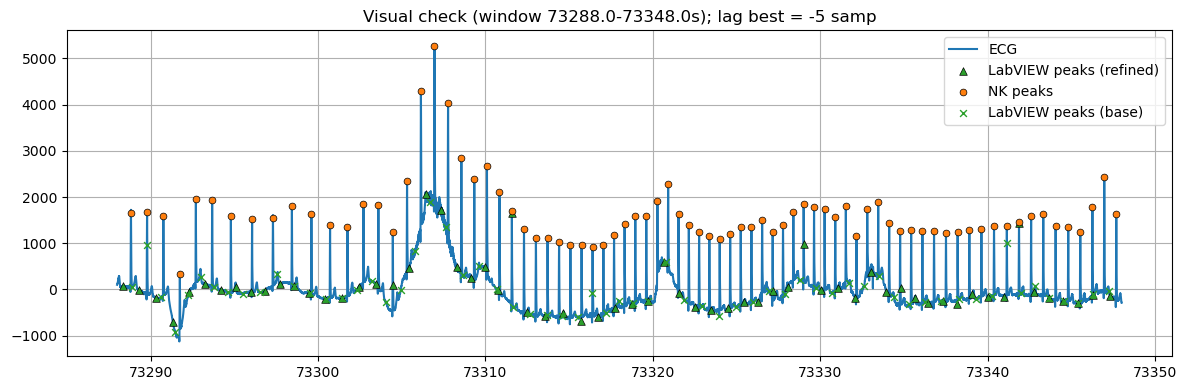

[PROOF] {'applied_offset_s': 0.0, 'best_lag_samples': -5, 'before_overlap_metrics': {'TP': 14938, 'FP': 152105, 'FN': 155156, 'Sensitivity': 0.08782202781991134, 'PPV': 0.08942607592057135, 'F1': 0.08861679376633237}, 'after_overlap_metrics': {'TP': 14877, 'FP': 152165, 'FN': 155217, 'Sensitivity': 0.08746340258915658, 'PPV': 0.08906143365141701, 'F1': 0.08825518485121732}}


In [10]:
TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
# LABVIEW_LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"
LABVIEW_LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-NewFile.lvm"
print("Edit TDMS_PATH and LABVIEW_LVM_PATH, then run main(...).")
# Example:
out = main(TDMS_PATH, LABVIEW_LVM_PATH, KNOWN_LAB_INITIAL_SKIP_S=316.0, TOL_MS=40.0, MAX_LAG_MS=120.0,
           PLOT_START_S=73288.0, PLOT_DUR_S=60.0, RUN_SWEEP=False, return_objects=True)


In [11]:
# From your 'out' dict
ecg         = out["ecg"]
fs          = out["fs"]
nk_idx      = out["nk_idx"]
lab_idx     = out["lab_idx"]         # refined (final)
lab_idx_base= rr_to_peak_samples(read_labview_rr(LABVIEW_LVM_PATH), fs, t0_s=out["base_offset_s"])

# A) Existing proof plot (now with nicer markers and optional base)
# proof = prove_alignment(
#     ecg=ecg, fs=fs,
#     lab_idx=lab_idx, nk_idx=nk_idx,
#     tol_ms=out["TOL_MS"] if "TOL_MS" in out else 40,
#     best_off_s=0.0,
#     max_lag_ms=out["MAX_LAG_MS"] if "MAX_LAG_MS" in out else 150,
#     plot_window=(73288.0, 60.0),
#     lab_idx_base=lab_idx_base
# )


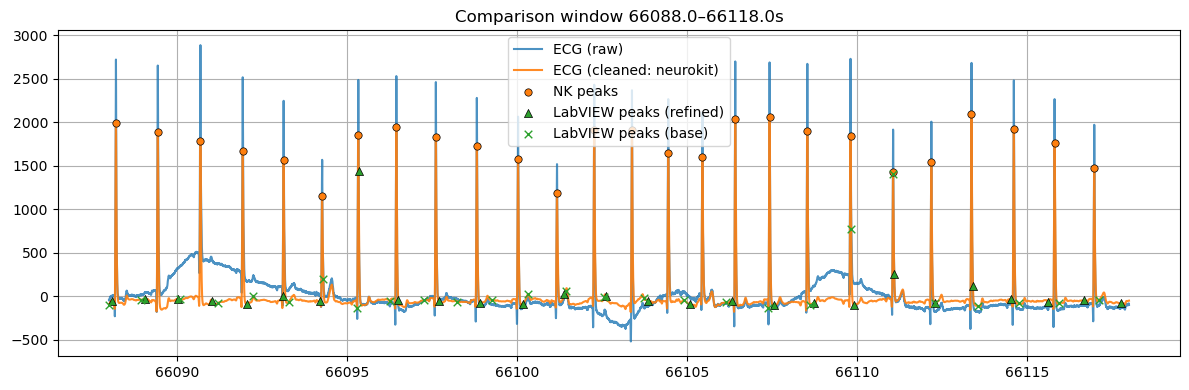

In [12]:
extract_offset_s = 7200.0
# B) Extra comparison plot (short window)
plot_comparison_window(
    ecg, fs, nk_idx, lab_idx_refined=lab_idx, lab_idx_base=lab_idx_base,
    start_s=73288.0-extract_offset_s, dur_s=30.0, clean_method="neurokit"
)


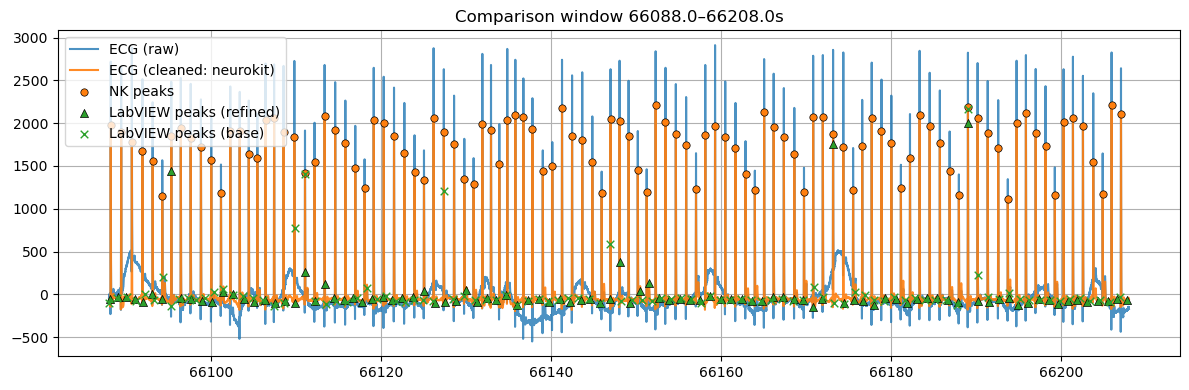

In [13]:
plot_comparison_window(
    ecg, fs, nk_idx, lab_idx_refined=lab_idx, lab_idx_base=lab_idx_base,
    start_s=73288.0-extract_offset_s, dur_s=120.0, clean_method="neurokit"
)

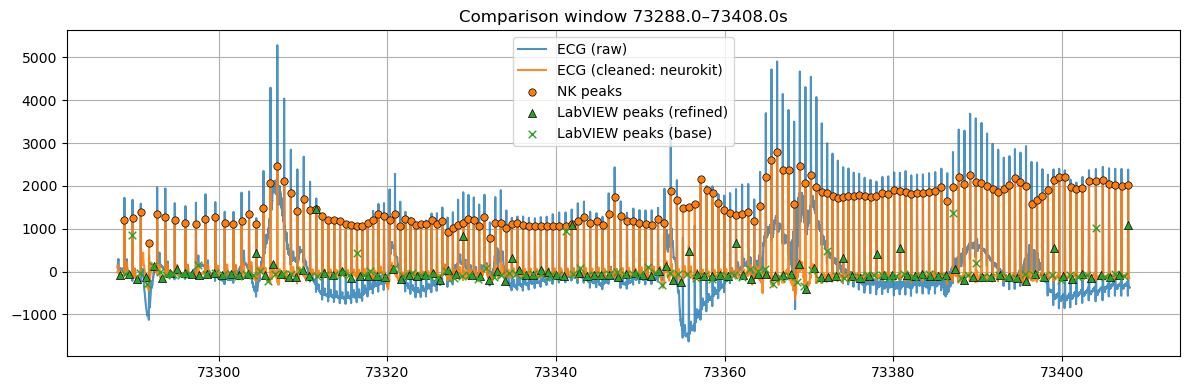

In [14]:
plot_comparison_window(
    ecg, fs, nk_idx, lab_idx_refined=lab_idx, lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=120.0, clean_method="neurokit"
)
# df = out["offsets_df"]
# df.plot(x="offset_s", y="TP", figsize=(6,2))


In [15]:
def plot_raw_clean_with_peaks(
    ecg, fs,
    nk_idx,
    lab_idx_refined,
    lab_idx_base=None,
    start_s=100.0, dur_s=6.0,
    clean_method="neurokit",
    show_stems=False
):
    """
    Plotter kort vindue med:
      - ECG (raw, cleaned)
      - NK peaks (raw & cleaned)
      - LabVIEW peaks (raw & cleaned)
      - LabVIEW base (valgfri)
      - Alle farver og symboler unikke
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import neurokit2 as nk

    cleaned = nk.ecg_clean(ecg.to_numpy(), sampling_rate=int(fs), method=clean_method)

    s = int(start_s * fs); e = int((start_s + dur_s) * fs)
    t = np.arange(s, e) / fs
    raw_win = ecg.values[s:e]
    cln_win = cleaned[s:e]

    nk_loc   = nk_idx[(nk_idx >= s) & (nk_idx < e)] - s
    lab_loc  = lab_idx_refined[(lab_idx_refined >= s) & (lab_idx_refined < e)] - s
    base_loc = None
    if lab_idx_base is not None:
        base_loc = lab_idx_base[(lab_idx_base >= s) & (lab_idx_base < e)] - s

    plt.figure(figsize=(12, 5))

    # === Signaler ===
    plt.plot(t, raw_win, color="dimgray", alpha=0.75, label="ECG (raw)")
    plt.plot(t, cln_win, color="tab:blue", alpha=0.9, label=f"ECG (cleaned: {clean_method})")

    # Lodrette streger
    if show_stems:
        y0, y1 = np.percentile(raw_win, [5, 95])
        if nk_loc.size: plt.vlines(t[nk_loc], y0, y1, color="orange", alpha=0.1)
        if lab_loc.size: plt.vlines(t[lab_loc], y0, y1, color="green", alpha=0.1)

    # === Peaks på RAW ===
    if nk_loc.size:
        plt.scatter(t[nk_loc], raw_win[nk_loc],
                    s=28, color="tab:orange", edgecolors="k", linewidths=0.4,
                    zorder=3, label="NK peaks (raw)")

    if lab_loc.size:
        plt.scatter(t[lab_loc], raw_win[lab_loc],
                    s=34, marker="^", color="limegreen", edgecolors="k",
                    linewidths=0.4, zorder=3, label="LabVIEW refined (raw)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], raw_win[base_loc],
                    s=34, marker="x", color="mediumorchid", linewidths=1.0,
                    zorder=3, label="LabVIEW base (raw)")

    # === Peaks på CLEANED ===
    if nk_loc.size:
        plt.scatter(t[nk_loc], cln_win[nk_loc],
                    s=26, color="red", edgecolors="k", linewidths=0.4,
                    zorder=4, label="NK peaks (cleaned)")

    if lab_loc.size:
        plt.scatter(t[lab_loc], cln_win[lab_loc],
                    s=34, marker="^", color="forestgreen", edgecolors="k",
                    linewidths=0.4, zorder=4, label="LabVIEW refined (cleaned)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], cln_win[base_loc],
                    s=34, marker="x", color="deeppink", linewidths=1.0,
                    zorder=4, label="LabVIEW base (cleaned)")

    plt.title(f"Raw vs. Cleaned ECG with peaks — window {start_s:.1f}–{start_s+dur_s:.1f}s")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [µV]")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


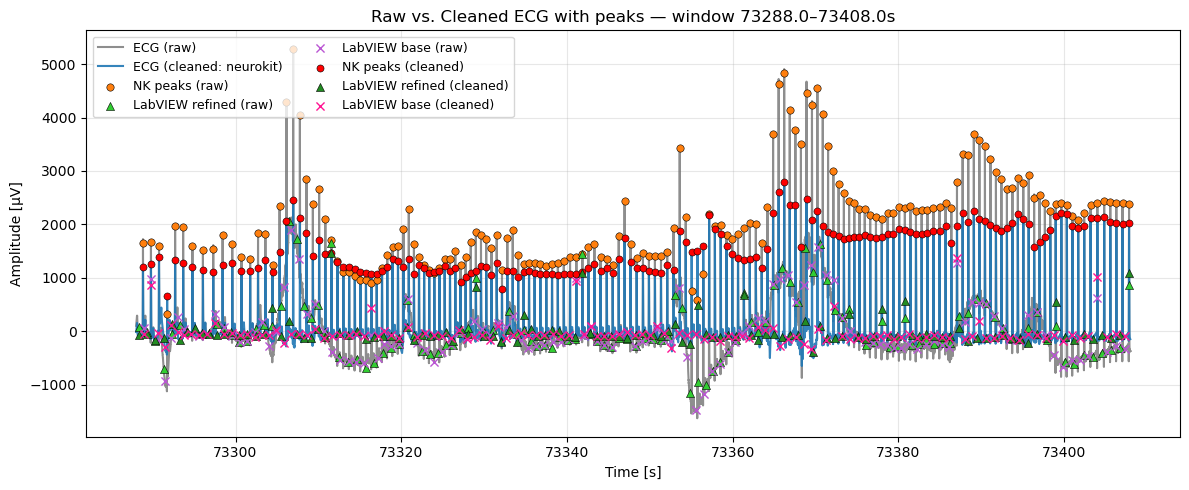

In [16]:
# typisk efter du har 'out = main(..., return_objects=True)'
ecg          = out["ecg"]
fs           = out["fs"]
nk_idx       = out["nk_idx"]
lab_idx      = out["lab_idx"]  # refined
# base-serien (valgfri)
lab_idx_base = rr_to_peak_samples(read_labview_rr(LABVIEW_LVM_PATH), fs, t0_s=out["base_offset_s"])

plot_raw_clean_with_peaks(
    ecg, fs,
    nk_idx,
    lab_idx_refined=lab_idx,
    lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=120.0,
    clean_method="neurokit",
    show_stems=False
)


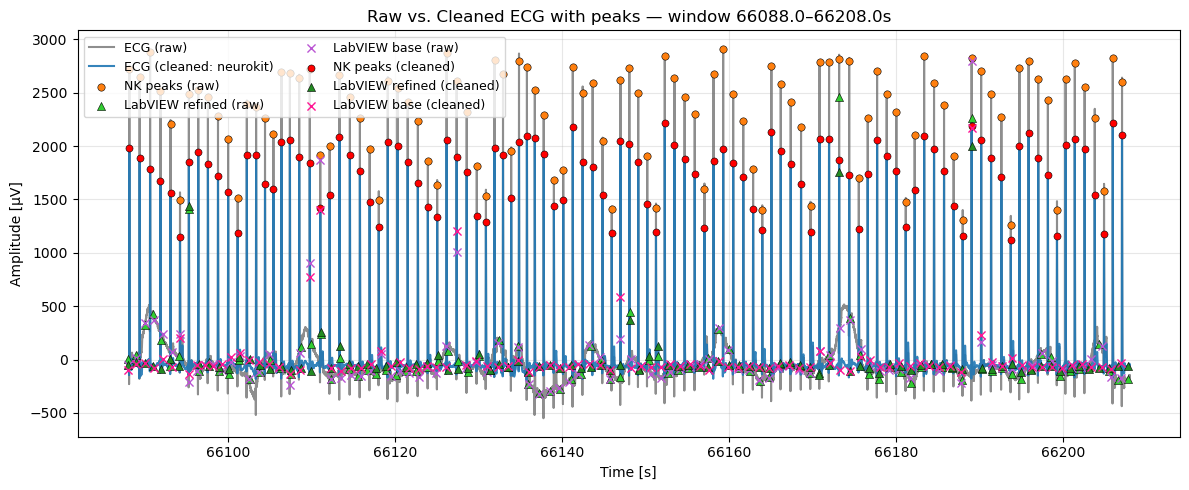

In [17]:
plot_raw_clean_with_peaks(
    ecg, fs,
    nk_idx,
    lab_idx_refined=lab_idx,
    lab_idx_base=lab_idx_base,
    start_s=66088.0, dur_s=120.0,
    clean_method="neurokit",
    show_stems=False
)


In [18]:
# Convert R-peaks (indices) to RR intervals (in seconds)
rr_intervals = np.diff(nk_idx) / fs

# Display the first few RR intervals
print(rr_intervals[:10])

[0.53125    0.4140625  0.74804688 0.34960938 0.7734375  0.77148438
 0.57617188 0.66210938 1.35742188 1.63671875]


In [19]:
starttime_lvm = datetime(2016,10,12,11,10,19,567)
starttime = datetime(2016,10,12,11,5,2)

offset = (starttime_lvm - starttime).total_seconds()
print(f"Offset in seconds: {offset}")


Offset in seconds: 317.000567


In [20]:
# Create copy of rr_intervals skipping the offset amount of rr intervals in the start
cumulative_time = np.cumsum(rr_intervals)
skip_time = offset
skip_indices = np.where(cumulative_time < skip_time)[0]
adjusted_rr_intervals = rr_intervals[skip_indices[-1]+1:] if len(skip_indices) > 0 else rr_intervals
print(adjusted_rr_intervals[:10])
print(len(adjusted_rr_intervals))

[1.83007812 2.46484375 4.79882812 1.3203125  0.38476562 1.21679688
 1.109375   0.57617188 3.95898438 0.55664062]
167077


In [21]:
#Convert Lab_idx to RR intervals (seconds)
lab_rr_intervals = np.diff(lab_idx_base) / fs
len(lab_rr_intervals)

170108

In [22]:
print(min(lab_rr_intervals), max(lab_rr_intervals), np.mean(lab_rr_intervals))
print(min(adjusted_rr_intervals), max(adjusted_rr_intervals), np.mean(adjusted_rr_intervals))

0.25 2.248046875 0.943144105050174
0.30859375 34.244140625 0.9620273441474589


In [23]:
# Calculate how many RR intervals in adjusted_rr_intervals is longer than max of lab_rr_intervals
num_longer_intervals = np.sum(adjusted_rr_intervals > max(lab_rr_intervals))
print(f"Number of RR intervals in adjusted_rr_intervals longer than max of lab_rr_intervals: {num_longer_intervals}")
# Calculate sum of those intervals
sum_longer_intervals = np.sum(adjusted_rr_intervals[adjusted_rr_intervals > max(lab_rr_intervals)])
print(f"Sum of RR intervals in adjusted_rr_intervals longer than max of lab_rr_intervals: {sum_longer_intervals}")

Number of RR intervals in adjusted_rr_intervals longer than max of lab_rr_intervals: 365
Sum of RR intervals in adjusted_rr_intervals longer than max of lab_rr_intervals: 2201.880859375


In [24]:
# Setup a raw plot of the signal where those long intervals are located
import matplotlib.pyplot as plt

def event_metrics_overlap_lag(
    gold_idx: np.ndarray,
    test_idx: np.ndarray,
    fs: float,
    tol_ms: float = 40.0,
    max_lag_ms: float = 150.0,
    match_mode: str = "one_to_one"
) -> dict:
    """
    Compute event-based detection metrics (TP, FP, FN, Sensitivity, PPV, F1)
    between two sequences of event indices (e.g., R-peak locations),
    allowing for a best small lag correction and a tolerance window for matching.
    Parameters 
    ----------
    gold_idx : np.ndarray
        Indices of the "gold standard" events (e.g., LabVIEW R-peaks).
    test_idx : np.ndarray
        Indices of the "test" events (e.g., NeuroKit R-peaks).
    fs : float
        Sampling frequency in Hz.
    tol_ms : float, optional
        Tolerance window in milliseconds for matching events (default is 40.0 ms).
    max_lag_ms : float, optional
        Maximum lag in milliseconds to search for best alignment (default is 150.0 ms).
    match_mode : str, optional
        Matching mode: "one_to_one" for greedy 1-to-1 matching,
        "many_to_one" for dilation-based matching (default is "one_to_one").
    Returns
    -------
    dict
        A dictionary containing TP, FP, FN, Sensitivity, PPV, F1, best lag in samples,
        tolerance in samples, number of samples in overlap, overlap range, and match mode.
    """
    import numpy as np
    from scipy.signal import convolve

    # --- Create binary event series in overlap region ---
    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    N = hi - lo
    if N <= 0:
        raise ValueError("No temporal overlap between gold and test indices.")

    a = np.zeros(N, dtype=np.uint8)
    b = np.zeros(N, dtype=np.uint8)
    a[gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo] = 1
    b[test_idx[(test_idx >= lo) & (test_idx < hi)] - lo] = 1

    # --- Best lag search ---
    maxlag = int(round(max_lag_ms / 1000.0 * fs))
    bestlag = 0
    best = -1
    for lag in range(-maxlag, maxlag + 1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    # Shift according to bestlag and get back to *index-lists* in overlap
    if bestlag > 0:
        # b is shifted "forward" => drop first bestlag from a for aligned length
        a2 = a[bestlag:]; b2 = b[:-bestlag]; start = lo + bestlag
    elif bestlag < 0:
        a2 = a[:bestlag]; b2 = b[-bestlag:]; start = lo
    else:
        a2, b2 = a, b; start = lo

    g2 = np.flatnonzero(a2) + (start - lo)  # back to overlap axis
    t2 = np.flatnonzero(b2) + (start - lo)

    # --- Slack matching ---
    slack_samp = int(round(tol_ms / 1000.0 * fs))

    if match_mode == "many_to_one":
        # Your old method (dilation) – corresponds to "slack" window via convolution
        win = np.ones(2 * slack_samp + 1, dtype=int)
        TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
        FP = int(b2.sum() - TP)
        FN = int(a2.sum() - TP)
    elif match_mode == "one_to_one":
        # Greedy 1-to-1 matching within tolerance window
        g_used = np.zeros(len(g2), dtype=bool)
        t_used = np.zeros(len(t2), dtype=bool)
        TP = 0
        for i, tg in enumerate(g2):
            for j, tt in enumerate(t2):
                if not g_used[i] and not t_used[j]:
                    if abs(tt - tg) <= slack_samp:
                        TP += 1
                        g_used[i] = True
                        t_used[j] = True
                        break
        FP = int(len(t2) - TP)
        FN = int(len(g2) - TP)
    else:
        raise ValueError(f"Unknown match_mode: {match_mode}")
    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    f1 = 2 * sens * ppv / (sens + ppv) if (sens > 0 and ppv > 0) else np.nan

    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "Sensitivity": sens,
        "PPV": ppv,
        "F1": f1,
        "best_lag_samples": bestlag,
        "tolerance_samples": slack_samp,
        "num_samples_in_overlap": N,
        "overlap_range": (lo, hi),
        "match_mode": match_mode
    }

def _count_matches(g_idx, t_idx, fs, tol_ms=40.0):
    tol_s = tol_ms / 1000.0
    g = np.asarray(g_idx, int)
    t = np.asarray(t_idx, int)
    gt = g / fs; tt = t / fs
    i = j = 0; TP = 0
    while i < len(gt) and j < len(tt):
        dt = tt[j] - gt[i]
        if abs(dt) <= tol_s:
            TP += 1; i += 1; j += 1
        elif dt < -tol_s:
            j += 1
        else:
            i += 1
    return TP

def compute_refined_offset_around_base(
    base_offset_s: float,
    fs: float,
    lab_idx_base: np.ndarray,
    nk_idx: np.ndarray,
    *,
    refine_half_range_s: float = 30.0,
    refine_step_ms: float = 4.0,
    refine_first_s: Optional[float] = None,
    tol_ms: float = 40.0
) -> Tuple[float, pd.DataFrame]:
    """
    Refine offset between LabVIEW and NeuroKit R-peak indices
    by searching for best delta around a base offset.
    Parameters
    ----------
    base_offset_s : float
        Base offset in seconds to center the refinement around.
    fs : float
        Sampling frequency in Hz.
    lab_idx_base : np.ndarray
        LabVIEW R-peak indices built using the base offset.
    nk_idx : np.ndarray
        NeuroKit R-peak indices.
    refine_half_range_s : float, optional
        Half range in seconds for refinement search (default is 30.0 s).
    refine_step_ms : float, optional
        Step size in milliseconds for refinement search (default is 4.0 ms).
    refine_first_s : Optional[float], optional
        If provided, limit refinement to first N seconds of data (default is None).
    tol_ms : float, optional
        Tolerance window in milliseconds for matching events (default is 40.0 ms).
    Returns
    -------
    Tuple[float, pd.DataFrame]
        Refined offset in seconds and a DataFrame with delta vs TP counts.
    import pandas as pd
    """
    step_s = refine_step_ms / 1000.0
    deltas = np.arange(-refine_half_range_s, refine_half_range_s + step_s/2, step_s)

    rows = []
    for d in deltas:
        refined_lab_idx = lab_idx_base + int(round(d * fs))
        if refine_first_s is not None:
            max_sample = int(round(refine_first_s * fs))
            refined_lab_idx = refined_lab_idx[refined_lab_idx <= max_sample]
        tp = _count_matches(
            g_idx=refined_lab_idx,
            t_idx=nk_idx,
            fs=fs,
            tol_ms=tol_ms
        )
        rows.append({"delta_s": d, "TP": tp})

    df = pd.DataFrame(rows)
    best_row = df.loc[df["TP"].idxmax()]
    best_delta = best_row["delta_s"]
    refined_offset_s = base_offset_s + best_delta

    return refined_offset_s, df

def prove_alignment(
    ecg: pd.Series,
    fs: float,
    lab_idx: np.ndarray,
    nk_idx: np.ndarray,
    tol_ms: float = 40.0,
    best_off_s: float = 0.0,
    max_lag_ms: float = 150.0,
    plot_window: Tuple[float, float] = (100.0, 20.0),
    lab_idx_base: Optional[np.ndarray] = None
) -> dict:
    """
    Prove alignment between LabVIEW and NeuroKit R-peak indices
    by applying offset, computing metrics with lag, and plotting.
    Parameters
    ----------
    ecg : pd.Series
        ECG signal as a pandas Series.
    fs : float
        Sampling frequency in Hz.
    lab_idx : np.ndarray
        LabVIEW R-peak indices (refined).
    nk_idx : np.ndarray
        NeuroKit R-peak indices.
    tol_ms : float, optional
        Tolerance window in milliseconds for matching events (default is 40.0 ms).
    best_off_s : float, optional
        Offset in seconds to apply to NeuroKit indices (default is 0.0 s).
    max_lag_ms : float, optional
        Maximum lag in milliseconds to search for best alignment (default is 150.0 ms).
    plot_window : Tuple[float, float], optional
        Tuple of (start_s, dur_s) for plotting window (default is (100.0, 20.0)).
    lab_idx_base : Optional[np.ndarray], optional
        Optional LabVIEW base indices for plotting (default is None).
    Returns
    -------
    dict
        A dictionary containing applied offset, best lag in samples,
        before and after overlap metrics.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import convolve

    tol_samp = int(round(tol_ms / 1000.0 * fs))
    maxlag   = int(round(max_lag_ms / 1000.0 * fs))

    print("=== BEFORE OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}")



In [25]:
# Apply offset to NeuroKit indices
nk_idx_offset = nk_idx + int(round(out['refined_offset_s'] * fs))
print(f"NeuroKit idx (after applying offset {out['refined_offset_s']:+.3f}s): n={len(nk_idx_offset)}, min={nk_idx_offset.min()}, max={nk_idx_offset.max()}")

NeuroKit idx (after applying offset -5.653s): n=167188, min=-1945, max=82455359


In [26]:
# Sum the rr intervals in NK and lvm rr interevals
sum_nk = rr_intervals.sum()
sum_lvm = lab_rr_intervals.sum()
print(f"Sum of NK RR intervals: {sum_nk} seconds")
print(f"Sum of LVM RR intervals: {sum_lvm} seconds")
difference = sum_nk - sum_lvm
print(f"Difference in total duration: {difference} seconds")


Sum of NK RR intervals: 161049.421875 seconds
Sum of LVM RR intervals: 160436.357421875 seconds
Difference in total duration: 613.064453125 seconds


In [27]:
from __future__ import annotations

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

from scipy.signal import welch
from scipy import stats


In [28]:
@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float  # seizure start (s fra recording start)
    t1: float  # seizure end   (s fra recording start)


In [29]:
# Eksempel: byg liste af SeizureEvent fra din annoterings-DataFrame
# Tilpas kolonnenavne, så de matcher din egen df
seizure_events: List[SeizureEvent] = []

for _, row in df_ann.iterrows():
    ev = SeizureEvent(
        seizure_id=int(row["seizure_id"]),
        t0=float(row["seizure_start_s"]),
        t1=float(row["seizure_end_s"]),
    )
    seizure_events.append(ev)

len(seizure_events), seizure_events[:3]


NameError: name 'df_ann' is not defined

In [ ]:
def extract_segment(
    x: np.ndarray,
    fs: float,
    t0: float,
    t1: float,
) -> np.ndarray:
    """Extract ECG segment between t0–t1 seconds."""
    i0 = int(round(t0 * fs))
    i1 = int(round(t1 * fs))
    i0 = max(i0, 0)
    i1 = min(i1, len(x))
    return x[i0:i1]


In [ ]:
def compute_psd_features(
    x_seg: np.ndarray,
    fs: float,
    bands: Optional[Dict[str, Tuple[float, float]]] = None,
) -> Dict[str, float]:
    """
    Compute simple spectral features from a 1D ECG segment using Welch.
    Returns total power + band powers + relative band powers.
    """
    if bands is None:
        bands = {
            "band_0_5_5": (0.5, 5.0),
            "band_5_15": (5.0, 15.0),
            "band_15_40": (15.0, 40.0),
        }

    # If segment very short, return NaNs
    if len(x_seg) < 2 * fs:
        base = {"total_power": np.nan}
        for name in bands:
            base[f"{name}_power"] = np.nan
            base[f"{name}_rel_power"] = np.nan
        return base

    # Welch PSD
    nperseg = min(4 * int(fs), len(x_seg))
    f, Pxx = welch(x_seg, fs=fs, nperseg=nperseg)

    features: Dict[str, float] = {}
    total_power = np.trapz(Pxx, f)
    features["total_power"] = total_power

    for name, (f_lo, f_hi) in bands.items():
        mask = (f >= f_lo) & (f <= f_hi)
        if not np.any(mask):
            band_power = np.nan
        else:
            band_power = np.trapz(Pxx[mask], f[mask])
        features[f"{name}_power"] = band_power
        features[f"{name}_rel_power"] = band_power / total_power if total_power > 0 else np.nan

    return features


In [ ]:
def csi_modcsi(rr: np.ndarray) -> Tuple[float, float]:
    """
    Compute CSI and ModCSI on RR-intervals (seconds),
    using Poincaré-based SD1 and SD2 as in Jeppesen.
    """
    if len(rr) < 4:
        return np.nan, np.nan

    diff = np.diff(rr)
    summ = rr[:-1] + rr[1:]

    sd1 = np.std((np.sqrt(2) / 2.0) * diff, ddof=1)
    sd2 = np.std((np.sqrt(2) / 2.0) * summ, ddof=1)

    T = 4 * sd1
    L = 4 * sd2

    if T == 0:
        return np.nan, np.nan

    csi = L / T
    modcsi = (L ** 2) / T
    return csi, modcsi


def tachogram_slope(rr: np.ndarray, times: Optional[np.ndarray] = None) -> float:
    """
    Compute linear slope of tachogram (RR vs. time or index).
    """
    if len(rr) < 4:
        return np.nan

    if times is None:
        x = np.arange(len(rr))
    else:
        x = np.asarray(times)
        if x.shape != rr.shape:
            raise ValueError("times and rr must have the same shape")

    slope, _, _, _, _ = stats.linregress(x, rr)
    return slope

def compute_hrv_features(
    rr_times: np.ndarray,
    rr_intervals: np.ndarray,
    t0: float,
    t1: float,
) -> Dict[str, float]:
    """
    Compute HRV/CSI/ModCSI/slope features for RR intervals within [t0, t1].
    """
    rr_times = np.asarray(rr_times)
    rr_intervals = np.asarray(rr_intervals)

    mask = (rr_times >= t0) & (rr_times <= t1)
    rr_win = rr_intervals[mask]
    t_win = rr_times[mask]

    if rr_win.size < 10:
        return {
            "rr_mean": np.nan,
            "rr_std": np.nan,
            "hr_mean": np.nan,
            "hr_std": np.nan,
            "csi": np.nan,
            "modcsi": np.nan,
            "slope": np.nan,
            "modcsi_x_slope": np.nan,
        }

    rr_mean = float(np.mean(rr_win))
    rr_std = float(np.std(rr_win, ddof=1))
    hr = 60.0 / rr_win
    hr_mean = float(np.mean(hr))
    hr_std = float(np.std(hr, ddof=1))

    csi, modcsi = csi_modcsi(rr_win)
    slope = tachogram_slope(rr_win, t_win)

    return {
        "rr_mean": rr_mean,
        "rr_std": rr_std,
        "hr_mean": hr_mean,
        "hr_std": hr_std,
        "csi": csi,
        "modcsi": modcsi,
        "slope": slope,
        "modcsi_x_slope": (
            modcsi * slope if np.isfinite(modcsi) and np.isfinite(slope) else np.nan
        ),
    }


In [ ]:
def build_feature_table_for_patient(
    patient_id: str,
    x: np.ndarray,
    fs: float,
    rr_times: np.ndarray,
    rr_intervals: np.ndarray,
    events: List[SeizureEvent],
    baseline_offset: float = 3600.0,  # 1 time efter seizure-start
) -> pd.DataFrame:
    """
    Build a feature table (seizure + baseline) for a single patient.
    """
    rows = []
    rec_duration_s = len(x) / fs

    for ev in events:
        dur = ev.t1 - ev.t0

        # ----- Seizure segment -----
        x_seiz = extract_segment(x, fs, ev.t0, ev.t1)
        psd_seiz = compute_psd_features(x_seiz, fs)
        hrv_seiz = compute_hrv_features(rr_times, rr_intervals, ev.t0, ev.t1)

        row_seiz = {
            "patient_id": patient_id,
            "seizure_id": ev.seizure_id,
            "segment_type": "seizure",
            "t0": ev.t0,
            "t1": ev.t1,
            "duration_s": dur,
        }
        row_seiz.update(psd_seiz)
        row_seiz.update(hrv_seiz)
        rows.append(row_seiz)

        # ----- Baseline segment (samme længde, forskudt i tid) -----
        base_t0 = ev.t0 + baseline_offset
        base_t1 = base_t0 + dur

        if base_t1 <= rec_duration_s:
            x_base = extract_segment(x, fs, base_t0, base_t1)
            psd_base = compute_psd_features(x_base, fs)
            hrv_base = compute_hrv_features(rr_times, rr_intervals, base_t0, base_t1)

            row_base = {
                "patient_id": patient_id,
                "seizure_id": ev.seizure_id,
                "segment_type": "baseline",
                "t0": base_t0,
                "t1": base_t1,
                "duration_s": dur,
            }
            row_base.update(psd_base)
            row_base.update(hrv_base)
            rows.append(row_base)

    return pd.DataFrame(rows)


In [ ]:
patient_id = "P10"  # tilpas
df_features_p10 = build_feature_table_for_patient(
    patient_id=patient_id,
    x=x_all,
    fs=fs,
    rr_times=rr_times,
    rr_intervals=rr_intervals,
    events=seizure_events,
    baseline_offset=3600.0,
)

df_features_p10.head()


In [ ]:
out_path = BASE_DIR / "analysis" / f"{patient_id}_seizure_baseline_features.csv"
out_path.parent.mkdir(exist_ok=True, parents=True)
df_features_p10.to_csv(out_path, index=False)
out_path


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vælg et par nøgletal
key_features = ["hr_mean", "modcsi", "modcsi_x_slope", "band_0_5_5_rel_power"]

for feat in key_features:
    plt.figure(figsize=(5, 4))
    sns.boxplot(
        data=df_features_p10,
        x="segment_type",
        y=feat,
        order=["baseline", "seizure"],
    )
    plt.title(f"{feat}: seizure vs baseline ({patient_id})")
    plt.tight_layout()
    plt.show()


In [ ]:
feat = "modcsi_x_slope"

df_wide = (
    df_features_p10
    .pivot_table(index=["patient_id", "seizure_id"],
                 columns="segment_type",
                 values=feat)
    .reset_index()
)

plt.figure(figsize=(5, 4))
for _, row in df_wide.iterrows():
    plt.plot(["baseline", "seizure"], [row["baseline"], row["seizure"]], marker="o", alpha=0.6)

plt.ylabel(feat)
plt.title(f"Paired {feat}: baseline vs seizure ({patient_id})")
plt.tight_layout()
plt.show()
